In [1]:
import pandas as pd
import numpy as np
import zipfile

%matplotlib notebook
import matplotlib.pyplot as plt

plt.rcParams['toolbar'] = 'None' 

Load IdLookupTable

In [139]:
idLookUp = pd.read_csv('data/IdLookupTable.csv')
idLookUp.head()

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN


#### Loading data from zip files

In [112]:
z = zipfile.ZipFile('data/training.zip')
train = pd.read_csv(z.open('training.csv'))
z = zipfile.ZipFile('data/test.zip')
test = pd.read_csv(z.open('test.csv'))

In [114]:
train = train.dropna() # drop all rows that have missing values in them

convert images

In [115]:
train.Image = train.Image.apply(lambda im: np.reshape(np.fromstring(im, sep=' '),96*96))
train.Image2 = train.Image.apply(lambda img: img.reshape(96,96))
test.Image = test.Image.apply(lambda im: np.fromstring(im, sep=' '))
test.Image2 = test.Image.apply(lambda img: img.reshape(96,96))

Take a brief look on data

In [13]:
train[train.columns[0:-1]].head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [117]:
def plot_sample(x, y, axis):
    plt.imshow(x, cmap='gray')
    plt.scatter(y[0::2], y[1::2], marker='x', s=10)

In [259]:
def plot_test(y_pred, page):
    fig = plt.figure(figsize=(6, 6))
    fig.subplots_adjust(
        left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    
    for i in range(16*(page-1),16*page):
        ax = fig.add_subplot(4, 4, (i%16) + 1, xticks=[], yticks=[])
        plot_sample(test.Image2[i], y_pred[i], ax)

In [118]:
keypoints_columns = train.columns[0:-1]

<IPython.core.display.Javascript object>


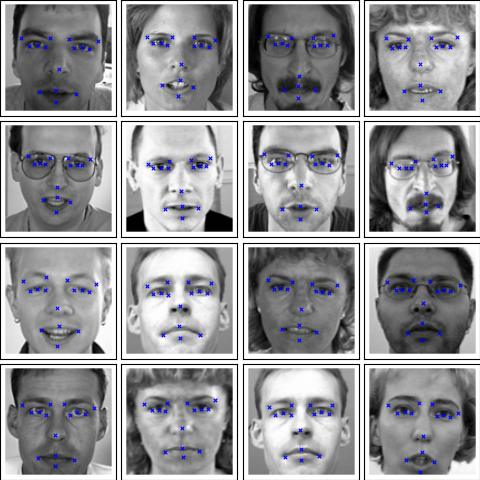

In [138]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

page = 3
for i in range(16*(page-1),16*page):
    ax = fig.add_subplot(4, 4, (i%16) + 1, xticks=[], yticks=[])
    plot_sample(train.Image2[i], train[keypoints_columns].iloc[i].values, ax)
    



# Simple avg benchmark

Calculate average value for each keypoint and use this value as result

In [131]:
benchmark = train[keypoints_columns].mean()
benchmark.head()

left_eye_center_x          66.221549
left_eye_center_y          36.842274
right_eye_center_x         29.640269
right_eye_center_y         37.063815
left_eye_inner_corner_x    59.272128
dtype: float64

In [134]:
rowids = [ row.RowId for index,row in idLookUp.iterrows()]
values_benchmark = [ benchmark[row.FeatureName] for index,row in idLookUp.iterrows()]

In [ ]:
benchmark_submission = pd.DataFrame(values_benchmark, index=rowids, columns=['Location'])
benchmark_submission.index.name='RowId'
benchmark_submission.head()

In [ ]:
benchmark_submission.to_csv('submissions/benchmark.csv')

I got 3.96244 score, which is too low, as I expected.

## Linear regression
Lets try simple linear regression model

In [20]:
from sklearn import linear_model

In [275]:
linear_clf =  linear_model.LinearRegression()
linear_clf.fit(np.vstack(train.Image.values), train[keypoints_columns].values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [276]:
y_linear = linear_clf.predict(np.vstack(test.Image.values))

<IPython.core.display.Javascript object>


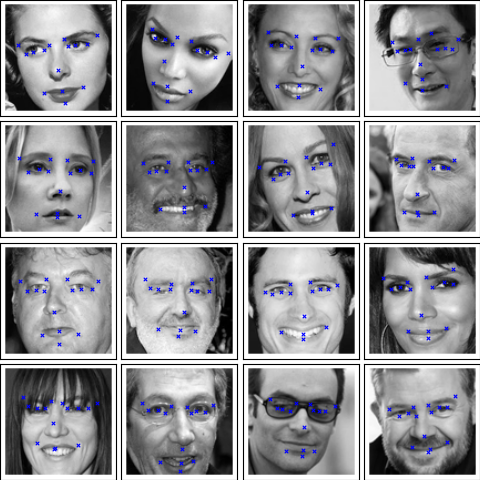

In [277]:
plot_test(y_linear, 30)

In [278]:
linear_df = pd.DataFrame(y_linreg)
linear_df.columns = keypoints_columns
linear_df.index = range(1,len(test)+1)
linear_df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
1,63.991754,39.197011,30.875136,39.039367,58.121246,40.283803,69.501190,39.562262,36.950609,38.974348,...,52.751978,49.137893,63.157389,74.622364,33.718146,75.280380,50.366953,65.123510,49.190326,83.168511
2,69.899118,35.184886,26.816475,35.448372,63.643535,36.660556,76.685998,36.141223,34.175274,36.283901,...,51.399808,60.926299,64.458165,78.479479,32.430233,78.387789,49.949315,74.199728,49.459616,90.860823
3,64.495864,36.071352,30.265977,36.852919,59.652582,37.326287,69.885023,36.849918,36.296491,37.840305,...,47.839041,57.459363,59.396803,76.417880,36.365455,75.636756,48.431169,70.435287,47.898488,87.830161
4,66.534467,38.691626,31.224919,39.782071,59.590984,40.257903,73.653232,40.138465,36.591574,40.498252,...,47.952127,50.477596,64.802529,78.337236,34.251084,78.413050,47.963727,70.367773,48.562618,83.476981
5,66.265270,35.340657,27.205546,37.508351,60.693033,36.710555,72.495006,36.438975,33.625896,38.005709,...,50.503372,52.679276,66.938157,75.216297,37.712722,76.952725,52.110959,68.725132,52.692635,83.600274


In [279]:
rowids = [ row.RowId for index,row in idLookUp.iterrows()]
values_linear = [ linear_df[row.FeatureName].ix[row.ImageId] for index,row in idLookUp.iterrows()]

In [280]:
values_linear = [ min(96,max(0, val)) for val in values_linear]

In [281]:
linear_submission = pd.DataFrame(values_linear, index=rowids, columns=['Location'])
linear_submission.index.name='RowId'
linear_submission.head()

,Location
RowId,
1,63.991754
2,39.197011
3,30.875136
4,39.039367
5,58.121246


In [282]:
linear_submission.to_csv('submissions/linear.csv')

Got even worse result than simple average!!! 4.138

Lets try to use Ridge regression, which is actually Linear regression with regularization

In [283]:
ridge_clf = linear_model.RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100])
ridge_clf.fit(np.vstack(train.Image.values), train[keypoints_columns].values)
ridge_clf.alpha_

0.01

In [284]:
y_ridge = ridge_clf.predict(np.vstack(test.Image.values))

<IPython.core.display.Javascript object>


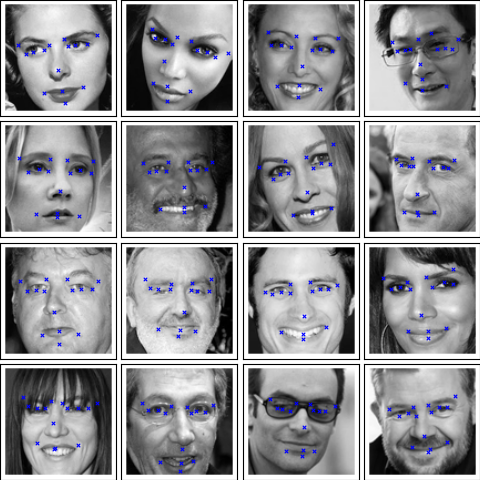

In [262]:
plot_test(y_linear,30)

<IPython.core.display.Javascript object>


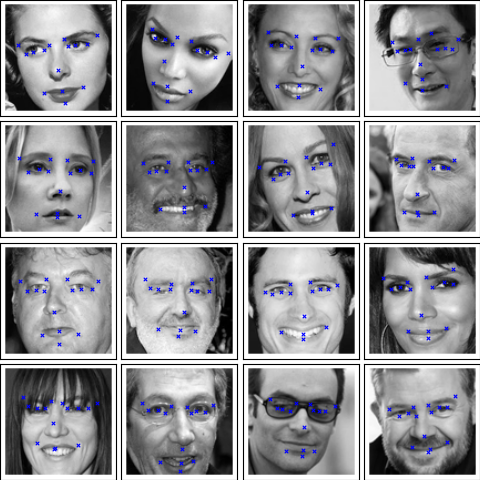

In [267]:
plot_test(y_ridge,30)

Calculate MSE for linear and ridge regression:

In [268]:
from sklearn import metrics

In [287]:
y_ridge_train = ridge_clf.predict(np.vstack(train.Image.values))
y_linear_train = linear_clf.predict(np.vstack(train.Image.values))

In [273]:
metrics.mean_squared_error(train[keypoints_columns].values,y_ridge_train)

5.3250254260142066e-15

In [288]:
metrics.mean_squared_error(train[keypoints_columns].values,y_linear_train)

8.0760947974167971e-27